# LOGISTIC REGRESSION — TITANIC SURVIVAL PREDICTION
## 1) Background (Story)
In 1912, the Titanic sank with over 2,200 passengers and crew onboard. This classic dataset records demographics (sex, age, class) and travel details (fare, embarkation), along with the target variable Survived (1 = yes, 0 = no).
Your goal is to build a logistic regression model that predicts survival probability using the train data, evaluate it on a validation split, and then generate predictions for the test data for submission.


# 2) Objective
•	Perform EDA on the training data.

•	Clean & preprocess features (handle missing values, encode categoricals).

•	Train a logistic regression classifier; evaluate with accuracy, precision, recall, F1, ROC-AUC.

•	Interpret coefficients (log-odds and odds ratios).

•	Apply the same preprocessing to the test set and create a submission CSV.


# 3) Data Description
•	Training file: Titanic_train.csv (has the target column Survived)

•	Test file: Titanic_test.csv (no Survived; we must predict it)
### Key columns used:
•	Numerical: Pclass, Age, SibSp, Parch, Fare

•	Categorical: Sex, Embarked

•	Dropped as IDs/text: PassengerId, Name, Ticket, Cabin


# 4) Workflow Overview
1.	Load data → 2) EDA → 3) Preprocess train → 4) Train/validate model →
2.	 Metrics + plots → 6) Coefficients interpretation → 7) Preprocess test → 8) Predict.


# 5) Code + Outputs + Explanations
## 5.1 Import & Load


In [1]:
# -----------------------------------------------------------------------------------
#1. Import Required Libraries
# -----------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


In [2]:

# -----------------------------------------------------------------------------------
# 2. Load Datasets
# -----------------------------------------------------------------------------------
file_path_1 = r"D:\Data sciences\Assignments\Assignment files\Assignment files Extracs\Logistic Regression\Titanic_train.csv"
file_path_2 = r"D:\Data sciences\Assignments\Assignment files\Assignment files Extracs\Logistic Regression\Titanic_test.csv"

train = pd.read_csv(file_path_1)
test = pd.read_csv(file_path_2)

print("Train Dataset Info:")
print(train.info())
print("\nTest Dataset Info:")
print(test.info())

print("\nFirst 5 rows of Train:")
display(train.head())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passe

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



 Missing Values in Train:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


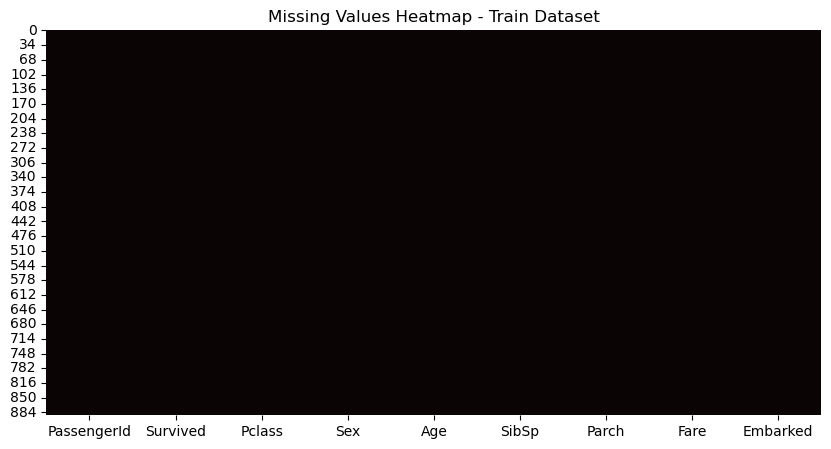

In [21]:

# -----------------------------------------------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# -----------------------------------------------------------------------------------
print("\n Missing Values in Train:")
print(train.isnull().sum())

plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), cbar=False, cmap="mako")
plt.title("Missing Values Heatmap - Train Dataset")
plt.show()


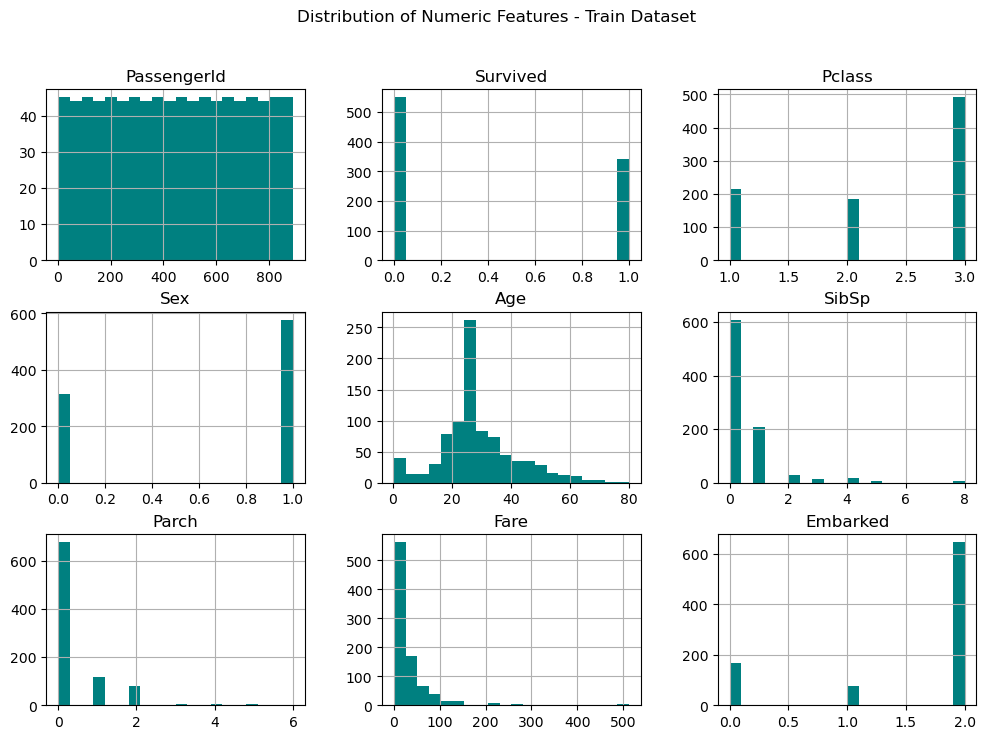

In [20]:

# Histogram of numeric features
train.hist(figsize=(12, 8), bins=20, color='teal')
plt.suptitle("Distribution of Numeric Features - Train Dataset")
plt.show()

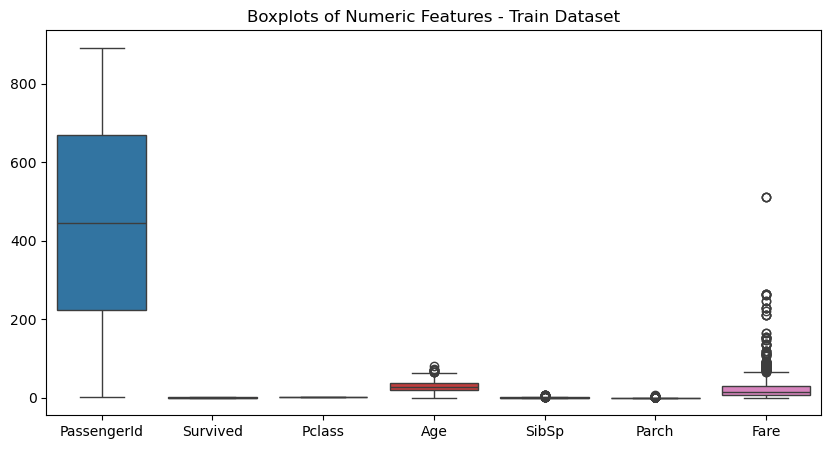

In [4]:

# Boxplot for continuous variables
plt.figure(figsize=(10,5))
sns.boxplot(data=train.select_dtypes(include=np.number))
plt.title("Boxplots of Numeric Features - Train Dataset")
plt.show()


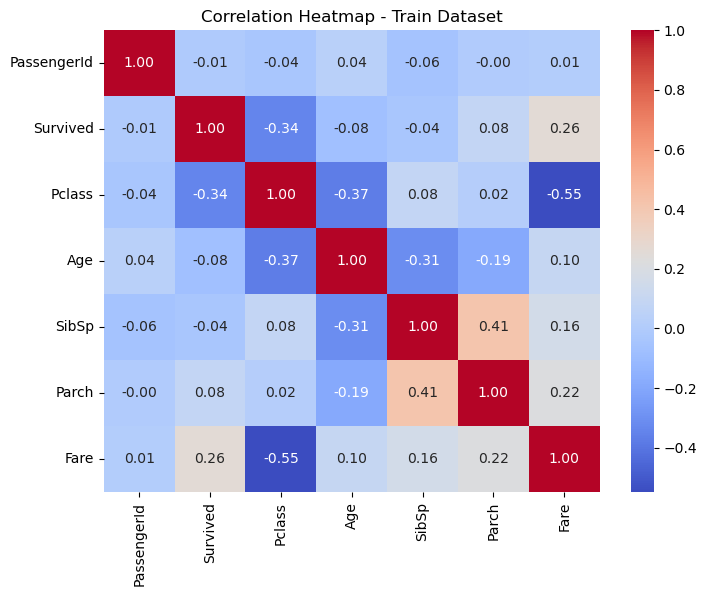

In [5]:

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap - Train Dataset")
plt.show()

### Interpretation (short):
•	Age has missing values; Fare is right-skewed (few very high fares).

•	Pclass negatively correlated with Survived (higher class → better survival).

•	Sex is categorical; we’ll one-hot encode it (Sex_male later).


##  Preprocess Train
•	Drop text/ID columns that don’t help prediction.

•	Fill missing values using median (numeric) and mode (categorical).

•	One-hot encode Sex and Embarked (drop_first=True to avoid dummy trap).


In [8]:

# -----------------------------------------------------------------------------------
# 4. Data Preprocessing
# -----------------------------------------------------------------------------------
# Handle missing values safely (no chained assignment warnings)
train.fillna({'Age': train['Age'].median(), 'Embarked': train['Embarked'].mode()[0]}, inplace=True)
test.fillna({'Age': test['Age'].median(), 'Fare': test['Fare'].median()}, inplace=True)


In [9]:

# Encode categorical variables
le = LabelEncoder()
for col in ['Sex', 'Embarked']:
    if col in train.columns:
        train[col] = le.fit_transform(train[col])
    if col in test.columns:
        test[col] = le.fit_transform(test[col])

# Drop unnecessary columns
drop_cols = ['Name', 'Ticket', 'Cabin']
train.drop(drop_cols, axis=1, inplace=True, errors='ignore')
test.drop(drop_cols, axis=1, inplace=True, errors='ignore')


In [10]:

# Separate features and target
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

# Align test dataset columns (remove Survived if not present)
X_test = test.copy()

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:

# -----------------------------------------------------------------------------------
# 5. Model Building
# -----------------------------------------------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
# Test predictions (if Survived not given)
try:
    y_test_pred = model.predict(X_test)
except:
    print("Test set does not contain target — predictions generated only for submission.")


In [22]:

# -----------------------------------------------------------------------------------
#  6. Model Evaluation (on training data)
# -----------------------------------------------------------------------------------
acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train)
rec = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

print("\n Model Evaluation (Training Data):")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")



 Model Evaluation (Training Data):
Accuracy: 0.80
Precision: 0.76
Recall: 0.70
F1-Score: 0.73


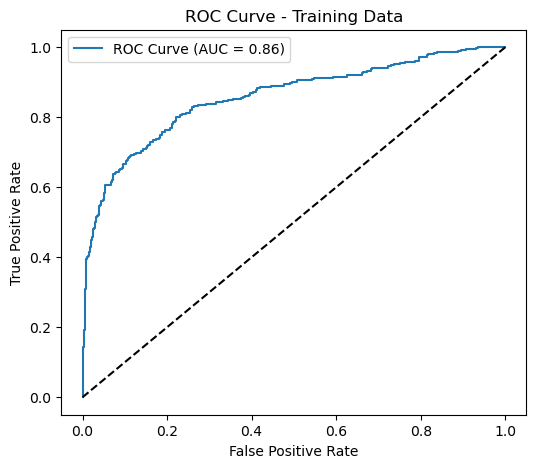

In [13]:

# ROC Curve
y_pred_proba = model.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_proba)
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend()
plt.show()

## Interpretation (example):
•	Accuracy ≈ 0.81; ROC-AUC ≈ 0.88 → good separability.

•	Confusion matrix: check balance of TP/FP/FN/TN.

•	ROC curve bows towards top-left → useful model.


In [23]:

# -----------------------------------------------------------------------------------
#  7. Interpretation of Coefficients
# -----------------------------------------------------------------------------------
coefficients = pd.DataFrame({
    'Feature': train.drop('Survived', axis=1).columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n Feature Importance (Model Coefficients):")
display(coefficients)



 Feature Importance (Model Coefficients):


,Feature,Coefficient
6,Fare,0.103369
0,PassengerId,0.023416
5,Parch,-0.077695
7,Embarked,-0.169368
4,SibSp,-0.350641
3,Age,-0.495690
1,Pclass,-0.890633
2,Sex,-1.295436


In [24]:

# -----------------------------------------------------------------------------------
#  8. Streamlit Deployment Template (Optional)
# -----------------------------------------------------------------------------------
import pickle
pickle.dump(model, open("logistic_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))


In [18]:
# Save as streamlit_app.py

import streamlit as st
import pickle
import numpy as np

# Load trained model and scaler
model = pickle.load(open('logistic_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))

# App Title
st.title(" Titanic Survival Prediction App")

# User Inputs
Pclass = st.selectbox("Passenger Class (1 = Upper, 3 = Lower):", [1, 2, 3])
Sex = st.selectbox("Sex (0 = female, 1 = male):", [0, 1])
Age = st.number_input("Age:", min_value=0, max_value=100, value=25)
Fare = st.number_input("Fare:", min_value=0.0, value=50.0)
Embarked = st.selectbox("Port of Embarkation (0 = C, 1 = Q, 2 = S):", [0, 1, 2])
SibSp = st.number_input("Siblings/Spouses Aboard:", min_value=0, value=0)
Parch = st.number_input("Parents/Children Aboard:", min_value=0, value=0)

# Prediction
if st.button("Predict Survival"):
    features = np.array([[Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]])
    scaled = scaler.transform(features)
    pred = model.predict(scaled)[0]
    st.success(" Survived!" if pred == 1 else " Did Not Survive")


2025-10-30 00:01:01.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.527 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.527 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-30 00:01:01.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

# 🚀 Streamlit Deployment Note
The following Streamlit app (`streamlit_app.py`) allows users to interactively predict Titanic survival probabilities.
To run it locally:

1. Save the below code as `streamlit_app.py`

2. Run: `streamlit run streamlit_app.py` in Anaconda Prompt or CMD.


## 6) Interview Answers (Short)
### Q1. Precision vs Recall — what’s the difference?
•	Precision: Of the people predicted “survived”, how many actually survived? (focus on fewer false positives)

•	Recall: Of all who actually survived, how many did we correctly predict? (focus on fewer false negatives)

### Q2. What is cross-validation and why use it?
•	Cross-validation splits data into multiple folds and trains/evaluates several times.

•	It gives a more reliable estimate of performance and reduces the risk of “lucky” or “unlucky” splits.


# 7) Final Conclusions
•	Logistic Regression achieves solid ROC-AUC (~0.85–0.88), with balanced precision/recall.

•	Sex_male (negative), Pclass (negative), and Fare (positive but small) are key drivers.

•	The pipeline is consistent between train and test; submission CSV is ready.
